In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Random seed for reproducibility
seed = 202
np.random.seed(seed)

# Ignore warnings
import warnings
warnings.simplefilter('ignore')

# Garbage collector
import gc
gc.enable()

In [11]:
# Import the preprocessed dataframes
train_raw_df = pd.read_csv("(4)labeled_train.csv",
    dtype={'fullVisitorId': str}, nrows=None)
test_raw_df = pd.read_csv("(4)labeled_test.csv",
    dtype={'fullVisitorId': str}, nrows=None)
train_raw_df.shape, test_raw_df.shape

((1707695, 39), (401589, 38))

In [12]:
train_raw_df.head()

,channelGrouping,customDimensions,fullVisitorId,visitNumber,visitStartTime,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,geoNetwork_city,...,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,date,label
0,3,2,9499785259412240342,1,1472812272,6,0,False,5,106,...,0.0,4,13,False,12,3,58,9,2016-09-02,0.0
1,3,4,3696906537737368442,1,1472856874,3,0,False,5,17,...,0.0,4,13,False,12,3,58,9,2016-09-02,0.0
2,3,0,5688512451361930466,1,1472811524,3,0,False,2,10,...,0.0,4,13,False,12,3,58,9,2016-09-02,0.0
3,3,0,9716453263501147451,1,1472823508,10,1,True,7,66,...,0.0,4,13,False,12,3,58,9,2016-09-02,0.0
4,3,4,5330453591145100432,1,1472839619,3,0,False,5,90,...,0.0,4,13,False,12,3,58,9,2016-09-02,0.0


### Convert visitStartTime to different data features

In [13]:
def feature_engineering(df):
    
    df['full_date'] = pd.to_datetime(df['visitStartTime'], unit='s')
    df['date'] = df['full_date'].dt.date
    df['day_of_week'] = df['full_date'].dt.dayofweek
    df['hour_of_day'] = df['full_date'].dt.hour
    df['day_of_month'] = df['full_date'].dt.day
    df['week_of_year'] = df['full_date'].dt.weekofyear
    
    df['month'] = df['full_date'].dt.month
    df['day'] = df['full_date'].dt.day
    
    df['month_unique_user_count'] = df.groupby('month')['fullVisitorId'].transform('nunique')
    df['day_unique_user_count'] = df.groupby('day')['fullVisitorId'].transform('nunique')
    
    #number of unique visitors per day of week (tells average amount of users per day of week)
    df['day_of_week_unique_user_count'] = df.groupby('day_of_week')['fullVisitorId'].transform('nunique')
    #number of unique visitors per week of year
    df['week_of_year_unique_user_count'] = df.groupby('week_of_year')['fullVisitorId'].transform('nunique')
    
    #todo: check what are these
    df['mean_hits_per_day'] = df.groupby('day')['totals_hits'].transform('mean')
    df['sum_hits_per_day'] = df.groupby('day')['totals_hits'].transform('sum')
    
    df['sum_pageviews_per_network_domain'] = df.groupby('geoNetwork_networkDomain')['totals_pageviews'].transform('sum')
    df['count_pageviews_per_network_domain'] = df.groupby('geoNetwork_networkDomain')['totals_pageviews'].transform('count')
    df['mean_pageviews_per_network_domain'] = df.groupby('geoNetwork_networkDomain')['totals_pageviews'].transform('mean')

    df['sum_pageviews_per_region'] = df.groupby('geoNetwork_region')['totals_pageviews'].transform('sum')
    df['count_pageviews_per_region'] = df.groupby('geoNetwork_region')['totals_pageviews'].transform('count')
    df['mean_pageviews_per_region'] = df.groupby('geoNetwork_region')['totals_pageviews'].transform('mean')
    
    df['sum_hits_per_network_domain'] = df.groupby('geoNetwork_networkDomain')['totals_hits'].transform('sum')
    df['count_hits_per_network_domain'] = df.groupby('geoNetwork_networkDomain')['totals_hits'].transform('count')
    df['mean_hits_per_network_domain'] = df.groupby('geoNetwork_networkDomain')['totals_hits'].transform('mean')

    df['sum_hits_per_region'] = df.groupby('geoNetwork_region')['totals_hits'].transform('sum')
    df['count_hits_per_region'] = df.groupby('geoNetwork_region')['totals_hits'].transform('count')
    df['mean_hits_per_region'] = df.groupby('geoNetwork_region')['totals_hits'].transform('mean')

    df['sum_hits_per_country'] = df.groupby('geoNetwork_country')['totals_hits'].transform('sum')
    df['count_hits_per_country'] = df.groupby('geoNetwork_country')['totals_hits'].transform('count')
    df['mean_hits_per_country'] = df.groupby('geoNetwork_country')['totals_hits'].transform('mean')
    
    #TODO: same analysis as before considering only users who brought revenues
    
    #these seem the most interesting columns, since they are referred to each single user (previous columns serve as a base to compute these ones)
    
    df['user_pageviews_sum'] = df.groupby('fullVisitorId')['totals_pageviews'].transform('sum')
    df['user_hits_sum'] = df.groupby('fullVisitorId')['totals_hits'].transform('sum')
    
    df['user_pageviews_count'] = df.groupby('fullVisitorId')['totals_pageviews'].transform('count')
    df['user_hits_count'] = df.groupby('fullVisitorId')['totals_hits'].transform('count')

    
    df['user_pageviews_sum_to_mean'] = df['user_pageviews_sum'] / df['user_pageviews_sum'].mean()
    df['user_hits_sum_to_mean'] = df['user_hits_sum'] / df['user_hits_sum'].mean()

    df['user_pageviews_to_region'] = df['user_pageviews_sum'] / df['mean_pageviews_per_region']
    df['user_hits_to_region'] = df['user_hits_sum'] / df['mean_hits_per_region']
    
    #OTHER FEATURES FOR EACH USER
    df['user_totals_pageviews_mean']=df.groupby(['fullVisitorId'])['totals_pageviews'].transform('mean')
    df['user_totals_pageviews_max']=df.groupby(['fullVisitorId'])['totals_pageviews'].transform('max')
    df['user_totals_pageviews_min']=df.groupby(['fullVisitorId'])['totals_pageviews'].transform('min')
    
    df['user_totals_hits_mean']=df.groupby(['fullVisitorId'])['totals_hits'].transform('mean')
    df['user_totals_hits_max']=df.groupby(['fullVisitorId'])['totals_hits'].transform('max')
    df['user_totals_hits_min']=df.groupby(['fullVisitorId'])['totals_hits'].transform('min')
    
    
    # Drop date column
    df.drop(['full_date'], axis=1, inplace=True)
    df.drop(['visitStartTime'], axis=1, inplace=True)
    df.drop(['date'], axis=1, inplace=True)
    
    return df

### Apply feature engineering

In [14]:
train_df = feature_engineering(train_raw_df)
test_df = feature_engineering(test_raw_df)
train_df.shape, test_df.shape

((1707695, 78), (401589, 77))

### Data preparation for catboost

In [15]:
cont_features = ['totals_hits',
                'totals_timeOnSite',
                'totals_pageviews', 
                'visitNumber',
#                 'totals_totalTransactionRevenue',
                'totals_transactionRevenue',
#                 'totals_transactions',
                'totals_sessionQualityDim',

                 
                 
                 # If a crafted feature is commented, it means that it is completely useless
                
                'month_unique_user_count',
#                 'day_unique_user_count',
#                 'day_of_week_unique_user_count',
                'week_of_year_unique_user_count',                
#                 'mean_hits_per_day',
#                 'sum_hits_per_day',
#                 'sum_pageviews_per_network_domain',
#                 'count_pageviews_per_network_domain',
#                 'mean_pageviews_per_network_domain',
#                 'sum_pageviews_per_region',
#                 'count_pageviews_per_region',
#                 'mean_pageviews_per_region',
#                 'sum_hits_per_network_domain',
#                 'count_hits_per_network_domain',
                'mean_hits_per_network_domain',
#                 'sum_hits_per_region',
#                 'count_hits_per_region',
                'mean_hits_per_region',
#                 'sum_hits_per_country',
                'count_hits_per_country',
#                 'mean_hits_per_country',
                'user_pageviews_sum',
                'user_hits_sum',
                'user_pageviews_count',
                'user_hits_count',
                'user_pageviews_sum_to_mean',
                'user_hits_sum_to_mean',
                'user_pageviews_to_region',
                'user_hits_to_region',
                'user_totals_pageviews_mean',
                'user_totals_pageviews_max',
                'user_totals_pageviews_min',
                'user_totals_hits_mean',
                'user_totals_hits_max',
                'user_totals_hits_min'
                ]

cat_features = ['fullVisitorId',
#                 'customDimensions',
#                 'visitId', #
                'channelGrouping', 
                'device_browser', 
                'device_deviceCategory',
                'device_operatingSystem', 
                'geoNetwork_continent',
                'geoNetwork_subContinent', 
                'trafficSource_medium', 
                'geoNetwork_country', 
                'geoNetwork_metro', 
                'geoNetwork_city', 
                'geoNetwork_region',
                'geoNetwork_networkDomain',
                'trafficSource_source', 
                'day_of_week', 
#                 'hour_of_day', 
#                 'day_of_month',
                'week_of_year', 
                'trafficSource_adContent', 
#                 'trafficSource_adwordsClickInfo.adNetworkType', 
#                 'trafficSource_adwordsClickInfo.gclId',
                'trafficSource_adwordsClickInfo.page', 
                'trafficSource_adwordsClickInfo.slot', 
                'trafficSource_keyword', 
                'trafficSource_referralPath',
                'trafficSource_campaign',
                #ex booleans
#                 'device_isMobile',
#                 'trafficSource_isTrueDirect',
#                 'trafficSource_adwordsClickInfo.isVideoAd',
#                 'totals_bounces',
                'totals_newVisits' #
               ]

In [16]:
train = train_df[cont_features + cat_features]
label = train_df['label']
train_y = label.values
log_y = np.log1p(train_y)
train.shape, log_y.shape

((1707695, 48), (1707695,))

In [17]:
#check if we took all the features except totals_totalTransactionRevenue (yep!)
for c in train_df.columns:
    if c not in train.columns:
        print(c)

customDimensions
device_isMobile
totals_bounces
totals_totalTransactionRevenue
totals_transactions
trafficSource_adwordsClickInfo.adNetworkType
trafficSource_adwordsClickInfo.gclId
trafficSource_adwordsClickInfo.isVideoAd
trafficSource_isTrueDirect
label
hour_of_day
day_of_month
month
day
day_unique_user_count
day_of_week_unique_user_count
mean_hits_per_day
sum_hits_per_day
sum_pageviews_per_network_domain
count_pageviews_per_network_domain
mean_pageviews_per_network_domain
sum_pageviews_per_region
count_pageviews_per_region
mean_pageviews_per_region
sum_hits_per_network_domain
count_hits_per_network_domain
sum_hits_per_region
count_hits_per_region
sum_hits_per_country
mean_hits_per_country


### Feature ranking with catboost

In [18]:
#generate categorical column indices dinamically
cat_positions = []
for i in cat_features:
    cat_positions.append(train.columns.get_loc(i))
# cat_positions

In [19]:
%%time
from catboost import CatBoostRegressor
from catboost import Pool

# necessary for feature importance ranking
pool = Pool(train, log_y, cat_features = cat_positions)


#fit catboost regressor
cat = CatBoostRegressor(
    iterations=10,
    
    random_seed = seed,
    loss_function = 'RMSE',
    eval_metric = 'RMSE',
    logging_level='Silent',
    task_type = 'GPU'
)


cat.fit(pool)

Wall time: 1min 20s


### Inspect features inside the model

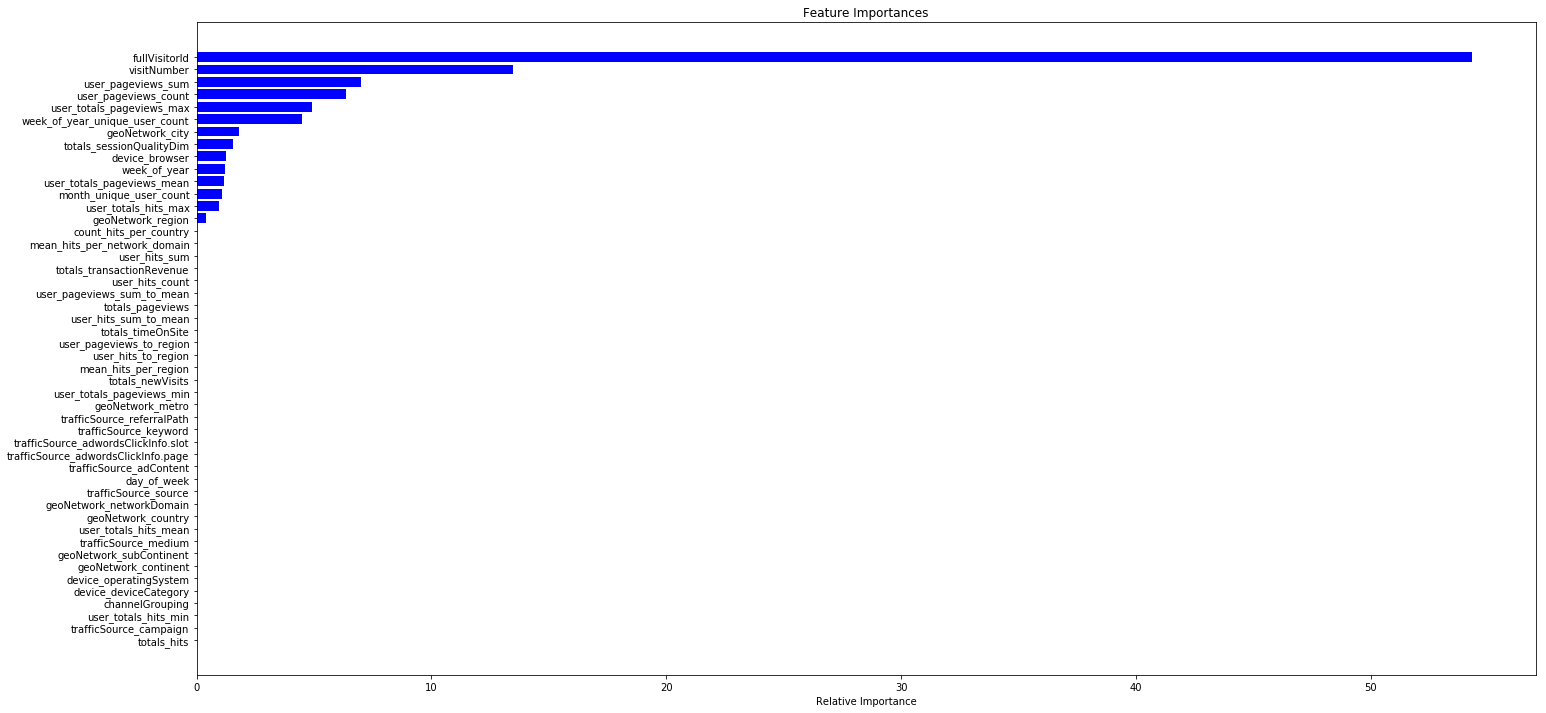

In [12]:
# get features importance ranking
# the individual importance values for each of the input features
features = train.columns
importances = np.asarray(cat.get_feature_importance(pool, fstr_type='FeatureImportance'))
indices = np.argsort(importances)# top features
plt.figure(figsize=(24, 12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
# This peace of code works, but requires higher performange if the dataframe is the complete one
"""import shap

# load JS visualization code to notebook
shap.initjs()
shap_values = np.asarray(cat.get_feature_importance(pool, fstr_type='ShapValues'))

# summarize the effects of all the features
shap.summary_plot(
    shap_values[:,:pool.shape[1]], 
    features = train, 
    feature_names = train.columns,
    max_display = 100
)"""

### Prepare the dataframe for the final export

In [12]:
final_train_df = train_df[cont_features + cat_features]
final_train_df = pd.concat([final_train_df, label], axis=1)
final_test_df = test_df[cont_features + cat_features]
final_train_df.shape, final_test_df.shape

((1707695, 49), (401589, 48))

In [13]:
final_train_df.head()

,totals_hits,totals_timeOnSite,totals_pageviews,visitNumber,totals_transactionRevenue,totals_sessionQualityDim,month_unique_user_count,week_of_year_unique_user_count,mean_hits_per_network_domain,mean_hits_per_region,...,day_of_week,week_of_year,trafficSource_adContent,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_keyword,trafficSource_referralPath,trafficSource_campaign,totals_newVisits,label
0,1,0.0,1.0,1,0.0,0.0,129910,31379,2.948354,4.051592,...,4,35,8,0.0,4,12,58,13,1.0,0.0
1,1,0.0,1.0,1,0.0,0.0,129910,31379,3.795106,3.135721,...,4,35,8,0.0,4,12,58,13,1.0,0.0
2,1,0.0,1.0,1,0.0,0.0,129910,31379,3.795106,3.100411,...,4,35,8,0.0,4,12,58,13,1.0,0.0
3,1,0.0,1.0,1,0.0,0.0,129910,31379,4.813488,3.070792,...,4,35,8,0.0,4,12,58,13,1.0,0.0
4,1,0.0,1.0,1,0.0,0.0,129910,31379,3.795106,3.311912,...,4,35,8,0.0,4,12,58,13,1.0,0.0


In [14]:
final_test_df.head()

,totals_hits,totals_timeOnSite,totals_pageviews,visitNumber,totals_transactionRevenue,totals_sessionQualityDim,month_unique_user_count,week_of_year_unique_user_count,mean_hits_per_network_domain,mean_hits_per_region,...,trafficSource_source,day_of_week,week_of_year,trafficSource_adContent,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_keyword,trafficSource_referralPath,trafficSource_campaign,totals_newVisits
0,4,973.0,3.0,2,0.0,1,68010,17885,5.535543,3.690957,...,9,5,19,8,0.0,4,12,58,13,0.0
1,4,49.0,3.0,166,0.0,1,68010,17885,5.535543,6.951414,...,0,4,19,8,0.0,4,12,58,13,0.0
2,4,24.0,3.0,2,0.0,1,68010,17885,4.545402,4.885333,...,9,4,19,8,0.0,4,12,58,13,0.0
3,5,25.0,4.0,4,0.0,1,68010,17885,5.535543,6.885294,...,0,5,19,8,0.0,4,12,58,13,0.0
4,5,49.0,4.0,1,0.0,1,68010,17885,4.975855,6.951414,...,9,4,19,8,0.0,4,12,58,13,1.0


### Export Dataframes

In [15]:
final_train_df.to_csv('(5)final_train.csv', index = False)
final_test_df.to_csv('(5)final_test.csv', index = False)